Aim is to create a PMC model which can have more than one noise state, this will allow non-stationary or intermitent noise to be handled
create signals, i.e. filtered noise, and normal sine wave,
create FHMM classifier which is able to deal with it

This is working, but in the log domain, I need to combine the PMC mapping method with this to create a method which will allow me to work in the cept domain.

In [1]:
import sys

import spafe.utils.vis

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/fhmm_development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from spafe.features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)
from scipy import signal
from scipy.stats import multivariate_normal as mvn

<Figure size 240x240 with 0 Axes>

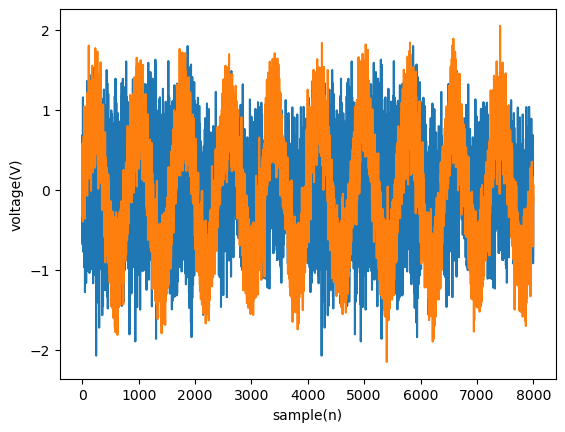

In [4]:
Fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)

n1 = np.random.normal(0, np.sqrt(0.1), sample)
n3 = np.random.normal(0, np.sqrt(0.58), sample)

# lpf
sos = signal.butter(10, 1500, 'lp', fs=Fs, output='sos')
n3_lpf = signal.sosfilt(sos, n3)

# hpf
sos = signal.butter(10, 1500, 'hp', fs=Fs, output='sos')
n3_hpf = signal.sosfilt(sos, n3)

# combine
noise_combined = np.append(n3_hpf[0:2000], n3_lpf[0:2000])
noise_combined = np.append(noise_combined, noise_combined)

s1 = np.sin(np.pi * f1 * x / Fs) + n1

s2 = noise_combined
plt.plot(x, s2)
plt.plot(x, s1)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

0.2886385656590796


2.863067388432748

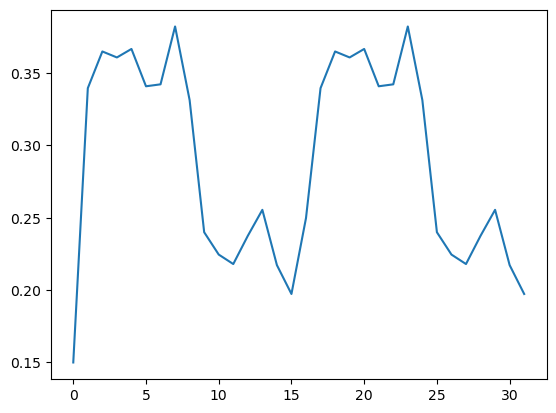

In [5]:
# snr before normalisation
ap = utils.periodic_power(s2, 500, 250)
plt.plot(ap)
print(np.mean(ap))
s1_ap = 0.58
s2_ap = 0.30
snr = 10 * np.log10(s1_ap / s2_ap)
snr

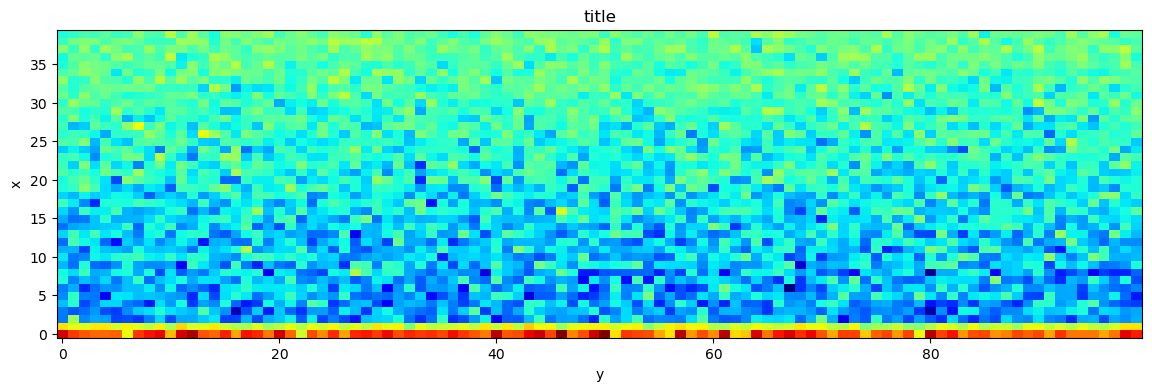

In [6]:
s1_feat = np.log(mfcc.mel_spectrogram(sig=s1, fs=8000, nfilts=40)[0])
s1_hmm = hmm.GaussianHMM(2)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

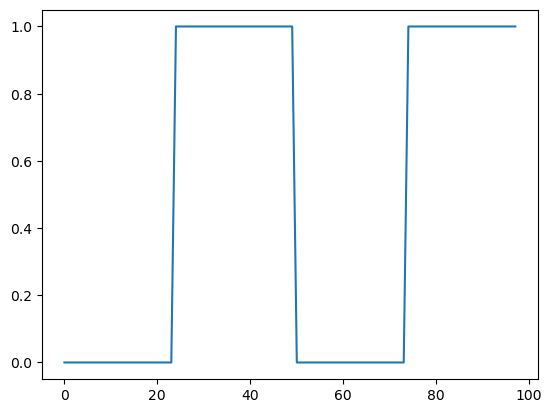

In [7]:
s2_feat = np.log(mfcc.mel_spectrogram(sig=s2, fs=8000, nfilts=40)[0])
s2_hmm = hmm.GaussianHMM(2)
s2_hmm.fit(s2_feat)
_, ss = s2_hmm.decode(s2_feat)
# s2_hmm_sampled, _ = s2_hmm.sample(100)
# vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')
plt.plot(ss)


In [7]:
s3 = s1 + s2
s3_features = np.log(mfcc.mel_spectrogram(sig=s3, fs=8000, nfilts=40)[0])

In [8]:
from classifiers.fhmm.fhmm_development.helper_functions import *

log_prob, [ss01, ss02] = viterbi_algorithm_parallel(s3_features, s1_hmm, s2_hmm)

NameError: name 's3_features' is not defined

<Figure size 240x240 with 0 Axes>

-4299.284167359604 -12594.23095374523


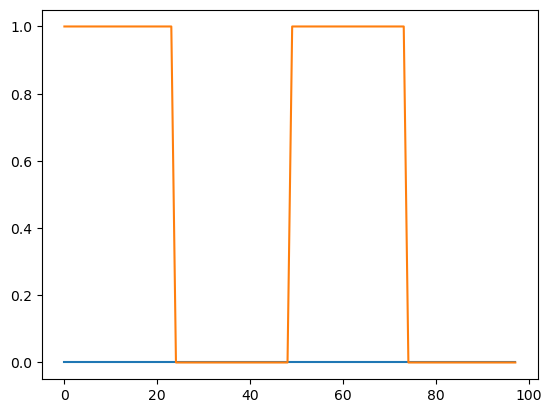

In [51]:
plt.plot(ss01)
plt.plot(ss02)
print(log_prob, s1_hmm.decode(s3_features)[0])